# Data Analysis of YouTube Travel Vlog Channels

## Introduction

#### What will I be doing in this project?
In this project I am going to conduct some exploratory data analysis on a selection of YouTube videos. I would like to find out if there are any key indicators with a link to the popularity of videos. This is interesting to me as it is a tool that content creators could use during the process of making their videos to improve performance. I'm going to explore some potential relationships between variables such as which key features of a video can indictate higher views.

For this project, I took inspiration and borrowed some code from Thu Vu's [video](https://www.youtube.com/watch?v=D56_Cx36oGY) so a big thank you to her!

#### Which videos am I analysing and why?
I am going to be using data from YouTube channels that belong to travel vloggers. The reason I choose these channels is because I enjoy their content. I am also taking some time to travel myself soon so I'm taking an extra interest in these videos and using them to help plan my trip!
The channels aren't all the same size, some have more views and subscribers than others. I am interested to see how the different channels perform, comparing the differences and similarities between each.

#### Where am I getting the data?
The data that I collect will be from the [YouTube API](https://developers.google.com/youtube/v3). Using this, I will be able to collect video and channel data from each channel that I specify. This can be done for any YouTube channel by obtaining the channel ID, as shown in Thu Vu's video linked above.

NOTE: I have hidden the YouTube API key that I used as it is not a good idea to make this publicly available. You should do the same if following these steps for your own analysis!

#### What are the steps involved?
First I will obtain the video data through the YouTube API. 
I'll then examine and clean this metadata. Some variables will need to be added and if there is unnecessary or unwanted data points these can be removed at this stage.
Next I will conduct the data analysis of the video data. With each piece of analysis I will explain what the data is telling us and look for insights by examining the relationship between variables.


###### Importing necessary libraries:

In [1]:
# Google API
from googleapiclient.discovery import build

# Standard python libraries
import pandas as pd
from IPython.display import JSON
import json
import numpy as np
import regex as re
import datetime as dt
from dateutil.relativedelta import relativedelta
import isodate
from statistics import mean

# Data visualisation libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud
import string
from cleantext import clean
from flair.models import TextClassifier
from flair.data import Sentence


%run config.ipynb # this line runs the config.ipynb file (hidden in GitHub), which stores my API key

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lukeb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lukeb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.
C:\Users\lukeb\OneDrive\Documents\Python-v2\lil_projects\youtube_analysis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Setting display options for printing Pandas dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_colwidth', 80)

## Functions used for obtaining video data

Before running the functions below, I need to follow a few steps:

* Create a new GCP project
* Request authorization credentials which produces an API key I can use
* Enable Youtube API and services



In [3]:
def get_channel_stats(youtube, channel_ids):
    '''
    Parameters:
    youtube - build object from the googleapiclient library
    channel_ids - a list of the channel IDs that I want data on
    
    This function returns a DataFrame containing key channel statistics of all channels.
    '''    
    all_data = []
    request = youtube.channels().list(
                part='snippet,contentDetails,statistics',
                id=','.join(channel_ids))
    response = request.execute() 
    
    for i in range(len(response['items'])): # the key 'items' in the response JSON dict gives a list of items, each one about a specified YT channel.
        data = dict(channelName = response['items'][i]['snippet']['title'],
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    totalVideos = response['items'][i]['statistics']['videoCount'],
                    playlistId = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)
    
    return pd.DataFrame(all_data)

In [4]:
def get_video_ids(youtube, playlist_id):
    '''
    Parameters:
    youtube - build object from the googleapiclient library
    playlist_ids - playlist ID of a channel
    
    This function returns a list of all videos in the playlist.
    '''    
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')
        
    return video_ids

In [5]:
def get_video_details(youtube, video_ids):
    """
    Parameters:
    youtube - build object from the googleapiclient library
    video_ids: list of video IDs
    
    This function returns a DataFrame with statistics of videos. These stats include the video 
    title, view count, like count and the date-time that the video was published at.
    """
    
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

In [6]:
def get_comments_in_videos(youtube, video_ids):
    """
    Get top level comments as text from all videos with given IDs. 
    I've chosen to only take the first 50 comments as there is a quote limit of Youtube API.
    
    Params:
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with video IDs and list of top comments.
    """
    all_comments = []
    
    for video_id in video_ids:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:50]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
            
        except: 
            print('Could not get comments for video ' + video_id) # If an error occurs while trying to obtain the comments then this line is printed
        
    return pd.DataFrame(all_comments)     

## Running functions

In [7]:
api_service_name = 'youtube'
api_version = 'v3'

# note that api_key given below is pulled from a config file in my local folder. This is purposefully
# not available in my version on GitHub.
youtube = build(
    api_service_name, api_version, developerKey=api_key)

# these are the channel IDs of the 6 travel vloggers that I will be analysing
channel_ids = [
               'UCpXwMqnXfJzazKS5fJ8nrVw', #Shiey
               'UC29vLPlafHcsqZu3L-Rk_pA', #Kurt Caz
               'UC7McxlM5qJVjqLBRYcHyylg', #Backpacker Ben
               'UCxDZs_ltFFvn0FDHT6kmoXA', # Bald and Bankrupt
               'UC0Ize0RLIbGdH5x4wI45G-A', #Drew Binsky
               'UCnZWFiZOtbKPWkRVSqhnJ8A' #Araya Vlogs
                ]

channel_stats_df = get_channel_stats(youtube, channel_ids)

In [8]:
channel_stats_df

,channelName,subscribers,totalVideos,playlistId
0,bald and bankrupt,3850000,250,UUxDZs_ltFFvn0FDHT6kmoXA
1,Drew Binsky,3870000,1026,UU0Ize0RLIbGdH5x4wI45G-A
2,Backpacker Ben,233000,205,UU7McxlM5qJVjqLBRYcHyylg
3,shiey,2530000,122,UUpXwMqnXfJzazKS5fJ8nrVw
4,Kurt Caz,2390000,449,UU29vLPlafHcsqZu3L-Rk_pA
5,Araya Vlogs,621000,311,UUnZWFiZOtbKPWkRVSqhnJ8A


In [18]:
channel_stats_df.dtypes

channelName    object
subscribers     int64
totalVideos     int64
playlistId     object
dtype: object

In [9]:
channel_list = list(channel_stats_df["channelName"].values) # It will be useful later to have a list of the channels I'm analysing
print(channel_list)

['bald and bankrupt', 'Drew Binsky', 'Backpacker Ben', 'shiey', 'Kurt Caz', 'Araya Vlogs']


In [10]:
# Convert data type of numeric columns
numeric_cols = ['subscribers', 'totalVideos']
channel_stats_df[numeric_cols] = channel_stats_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

Text(0.5, 1.0, 'Number of videos uploaded')

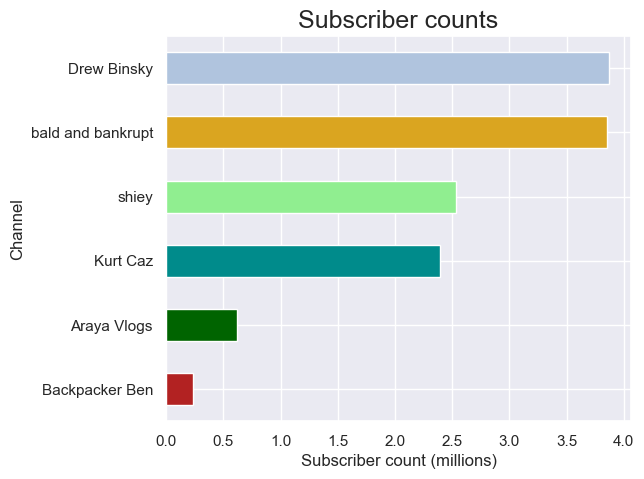

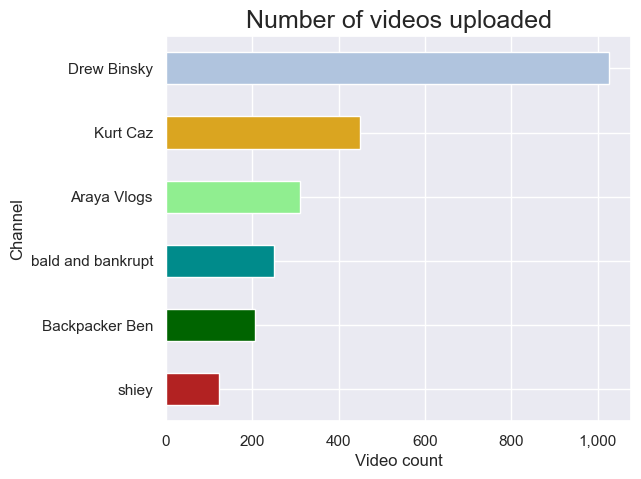

In [25]:
# Plotting subscriber counts

sns.set(rc={'figure.figsize':(6,5)})
c = ['firebrick', 'darkgreen', 'darkcyan', 'lightgreen', 'goldenrod', 'lightsteelblue']

channel_stats_df = channel_stats_df.sort_values("subscribers") # ordering data by number of subscribers
ax = channel_stats_df.plot.barh(x="channelName", y="subscribers", legend=None, color=c)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/1000000)))
ax.set(xlabel="Subscriber count (millions)", ylabel='Channel')
plt.title('Subscriber counts', fontsize=18)


# Plotting number of videos uploaded

channel_stats_df = channel_stats_df.sort_values("totalVideos")  # ordering data by number of videos the channel has uploaded
ax = channel_stats_df.plot.barh(x="channelName", y="totalVideos", legend=None, color=c)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.set(xlabel="Video count", ylabel='Channel')
plt.title('Number of videos uploaded', fontsize=18)

2 of the  channels I'm looking at (Bald & Bankrupt and Drew Binsky) have close to 4 million subscribers and these are some of the biggest travel vloggers on YouTube. Kurt Caz and shiey have slightly smaller channels, both around the 2.5 million subscribers mark. Backpacker Ben and Araya Vlogs are smaller still with under 1 million subscribers.

From the second plot, I can see Drew Binksy has uploaded over 1000 videos which is by far the highest amount.

###### Putting all video details into one dataframe:

In [26]:
playlist_ids = channel_stats_df["playlistId"].values
videos_df = pd.DataFrame() # this dataframe will contain video data from each of the channels

for playlist_id in playlist_ids: # each channel has a playlist_id
    video_ids = get_video_ids(youtube, playlist_id)
    video_details_df = get_video_details(youtube, video_ids) #this dataframe contains data from one channel, on each loop
    videos_df = pd.concat([videos_df, video_details_df], ignore_index=True) # adding the dataframe in above line to the total dataframe
    
videos_df.to_csv('videos_data.csv', index=False) # Saving for future reference

In [27]:
videos_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,KZBIsHTz_HE,shiey,Mission To Secured Satellite Broadcast Complex,PATREON: https://www.patreon.com/shiey\n\nWEBSITE: https://www.shiey.com/\n\...,"[shiey, ILLEGAL FREEDOM, abandoned satellite broadcast station, area 51, urb...",2023-09-02T18:55:23Z,254269,20950,None,810,PT15M,hd,false
1,usiT3sYp_VA,shiey,Cycling Journey To The Adriatic Sea | Part 4,PATREON: https://www.patreon.com/shiey\n\nWEBSITE: https://www.shiey.com/\n\...,"[shiey, ILLEGAL FREEDOM, Bosnia, Bosnia i Herzegovina, Bicycling, Adriatic S...",2023-08-17T16:50:51Z,471139,33356,None,1396,PT21M31S,hd,false
2,sPEQceHpcck,shiey,Cycling Journey To The Adriatic Sea | Part 3,PATREON: https://www.patreon.com/shiey\n\nWEBSITE: https://www.shiey.com/\n\...,"[shiey, ILLEGAL FREEDOM, Bosnia, Bosnia i Herzegovina, Bicycling, Adriatic S...",2023-07-20T16:01:39Z,494851,32747,None,1460,PT19M19S,hd,false
3,cj8slnNQVho,shiey,Cycling Journey To The Adriatic Sea | Part 2,PATREON: https://www.patreon.com/shiey\n\nWEBSITE: https://www.shiey.com/\n\...,"[shiey, ILLEGAL FREEDOM, Bosnia, Bosnia i Herzegovina, Bicycling, Adriatic S...",2023-06-09T18:22:37Z,635616,35406,None,1385,PT19M58S,hd,false
4,-vK_33wJMHo,shiey,shiey - feeling my best (Song),STREAM: https://ampl.ink/shiey-feeling-my-best\n\nLYRICS: https://shiey.com/...,"[shiey, ILLEGAL FREEDOM, shiey danger, shiey safety, shiey music]",2023-06-08T20:13:06Z,136036,7310,None,537,PT2M25S,hd,false


## Preprocessing and augmenting data

Before I start my analysis, the data needs to be cleaned. This will involve:
* converting the publishedAt column to a datetime column 
* converting the types of columns such as viewCount and commentCount to numeric
* amend the duration column so it contains the video length in minutes and seconds
* adding a column for the likes-to-views ratio of each video

In [28]:
# Converting the published date column to datetime object
videos_df["publishedAt"] = pd.to_datetime(videos_df["publishedAt"], format='%Y-%m-%dT%H:%M:%SZ')

In [29]:
# Converting column datatypes to numeric
numeric_cols = ['viewCount', 'commentCount', 'likeCount']
videos_df[numeric_cols] = videos_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Checking these datatypes look okay
print(videos_df.dtypes)

video_id                  object
channelTitle              object
title                     object
description               object
tags                      object
publishedAt       datetime64[ns]
viewCount                  int64
likeCount                  int64
favouriteCount            object
commentCount             float64
duration                  object
definition                object
caption                   object
dtype: object


In [30]:
# The video duration column is not currently in the format we want. For example, if a video has a 
# duration of 12 minutes 46 seconds, it's value is 'PT12M46S'. I will convert
# this to a float number correlating to the video's length in minutes.

videos_df['duration_minutes'] = videos_df['duration'].apply(lambda x: isodate.parse_duration(x))
videos_df['duration_minutes'] = videos_df['duration_minutes'].dt.total_seconds()/60
videos_df['duration_minutes'] = videos_df['duration_minutes'].apply(lambda x: round(x, 2))  # rounding the number of minutes to 2 decimal places

In [31]:
# Here I add a column for the number of likes a video receives per 100 views.

videos_df['likes_to_views'] = (videos_df['likeCount'] / videos_df['viewCount']) * 100

## Data analysis

### 1. Comparing views and likes-to-views ratio of the channels.

I'll only look at videos from the past year here as I want the data to be recent.

In [32]:
one_year_ago = dt.date.today() - relativedelta(years=1)
recent_vids_df = videos_df.copy()
recent_vids_df['publishedDate'] = recent_vids_df['publishedAt'].dt.date
recent_vids_df = recent_vids_df[recent_vids_df['publishedDate'] > one_year_ago]

In [33]:
mean_views = recent_vids_df.groupby('channelTitle')['viewCount'].mean()
mean_views = mean_views.sort_values()
mean_views = mean_views / 1000000  # to get mean views in millions

mean_likes_to_views = recent_vids_df.groupby('channelTitle')['likes_to_views'].mean()
mean_likes_to_views = mean_likes_to_views.sort_values()

C:\Users\lukeb\AppData\Local\Temp\ipykernel_34700\2451865030.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


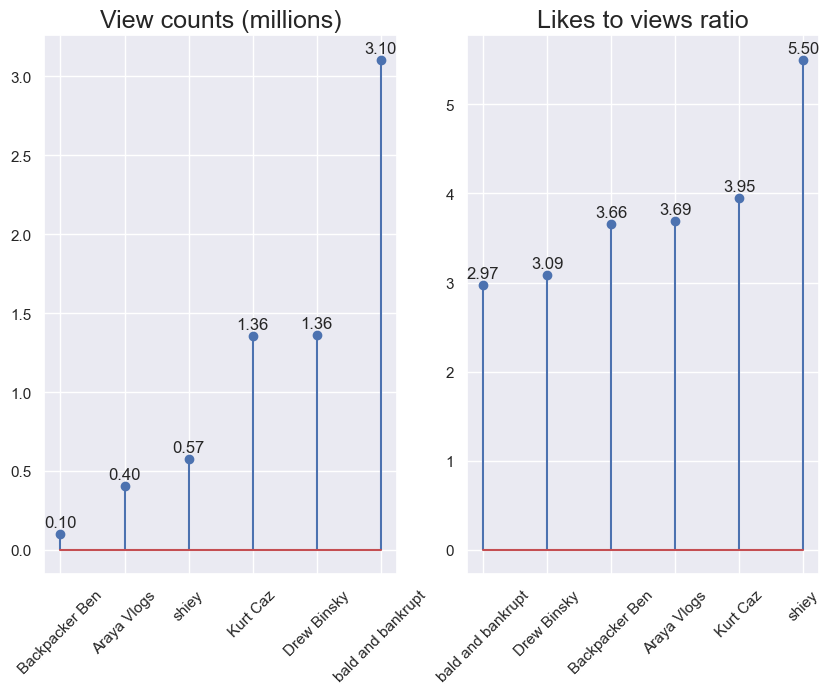

In [34]:
fig, axs = plt.subplots(figsize=(10,7), dpi= 100)

# Plotting view counts
plt.subplot(1,2,1)
stems =plt.stem(mean_views.index, mean_views.values)
plt.title('View counts (millions)', fontsize=18) #Adding a title
plt.xticks(rotation=45) # Formatting axis labels

for x,y in zip(mean_views.index, mean_views.values):
    plt.annotate('{:.2f}'.format(y), xy=(x,y), xytext=(0,5), textcoords='offset points',ha='center')

# Plotting likes-to-views ratio
plt.subplot(1,2,2)
plt.stem(mean_likes_to_views.index, mean_likes_to_views.values)
plt.title('Likes to views ratio', fontsize=18)
plt.xticks(rotation=45)

for x,y in zip(mean_likes_to_views.index, mean_likes_to_views.values):
    plt.annotate('{:.2f}'.format(y), xy=(x,y), xytext=(0,5), textcoords='offset points',ha='center')


In [35]:
recent_vids_df["channelTitle"].value_counts() # This gives us the number of videos uploaded in the past year

channelTitle
Kurt Caz             343
Araya Vlogs          141
Backpacker Ben        71
Drew Binsky           49
shiey                 16
bald and bankrupt     10
Name: count, dtype: int64

#### Analysis

In terms of view count, bald and bankrupt easily has the highest on average over the past year. Since August 2023 he has averaged almost 3.2 million views whereas Kurt Caz, who is next highest, has only 1.45 million. What's notable here is that bald and bankrupt has also uploaded the lowest number of videos in the past year at 11, less than one per month. It shows that often with these videos it is quality over quantity that is important. 

In terms of the like-to-view ratio, there is again a channel that is clearly the strongest with shiey at 5.29 likes per 100 views. The rest are relative close to each other with this ratio. It is interesting to see bald and bankrupt has the second lowest likes to views. This is partly because he is unlike a lot of youtubers and vloggers in that he doesn't ask for the viewers to like and subsbcribe. Can you tell I'm a fan of bald and bankrupt yet?!

### 2. Does video duration have a correlation with number of views/likes.

For this analysis I'm going to remove videos that are YouTube Shorts as I want to just focus on the standard form videos. 
I want to see if there's a sweet spot for the lengths of these longer types of videos and this would be distorted by including videos that have a maximum length of 60 seconds.


In [36]:
# Removing Shorts
print("Overall number of videos included in dataset: ", str(len(videos_df)))
standard_videos_df = videos_df[videos_df['duration_minutes'] > 1]
print("Number of videos with length > 1 minute: ", str(len(standard_videos_df)))

Overall number of videos included in dataset:  2362
Number of videos with length > 1 minute:  1916


<Figure size 1000x2000 with 0 Axes>

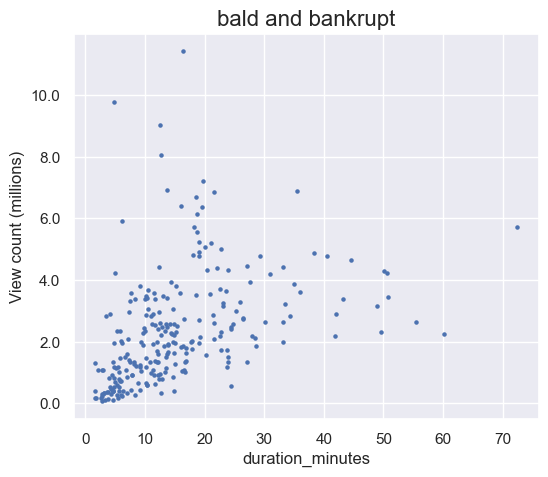

<Figure size 1000x2000 with 0 Axes>

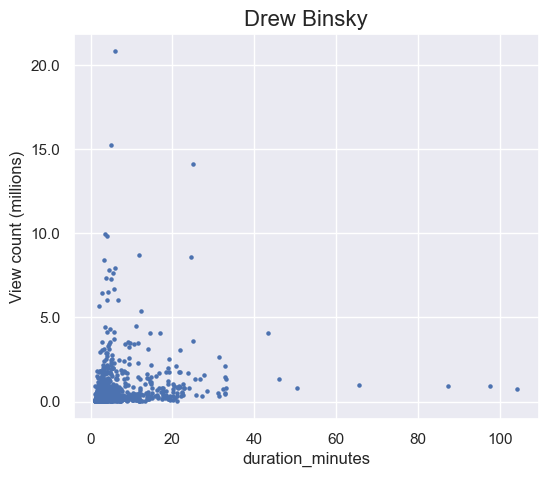

<Figure size 1000x2000 with 0 Axes>

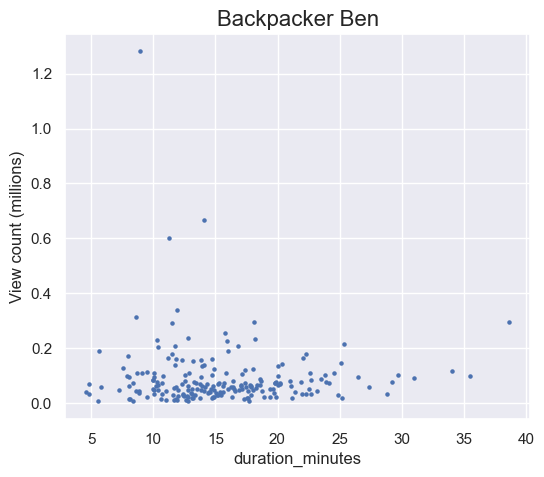

<Figure size 1000x2000 with 0 Axes>

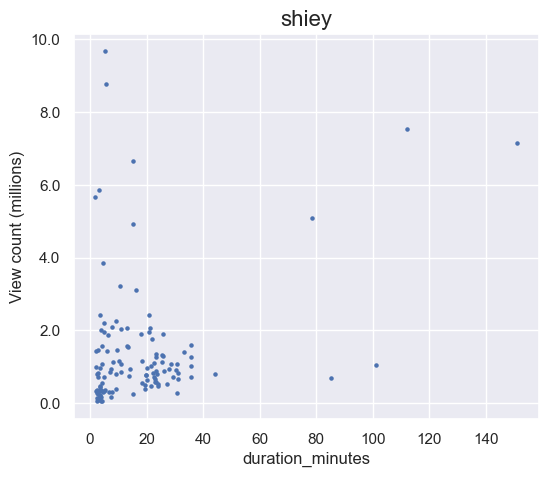

<Figure size 1000x2000 with 0 Axes>

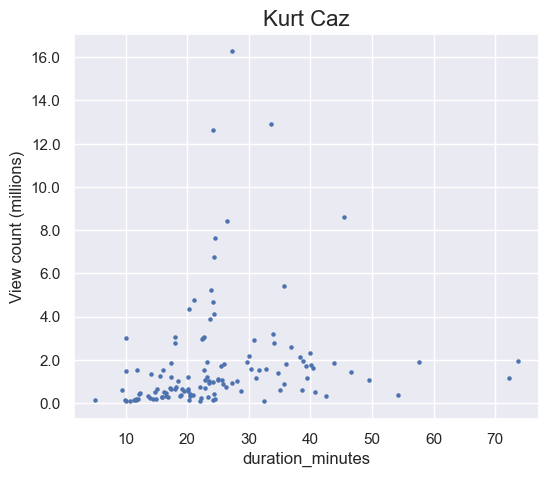

<Figure size 1000x2000 with 0 Axes>

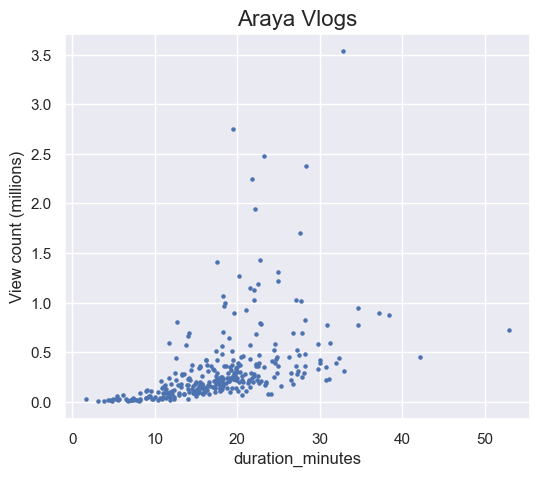

In [52]:
# Plotting view count against video duration for each of vlogger

for ind, channel in enumerate(channel_list):
    plt.figure(figsize=(10,20))
    channel_df = standard_videos_df[standard_videos_df['channelTitle'] == channel]
    ax = channel_df.plot.scatter(x="duration_minutes", y="viewCount", s=5)
    ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/1000000)))    # formatting y-labels
    ax.set(ylabel='View count (millions)')  # Setting y label
    ax.set_title(channel, fontsize=16) # Setting the in each plot to be channel name

#### Analysis

I chose to split up the data by channel for this analysis. It is clear to see from the scatter plots above that the channels have noticeably different relationships between the video duration and the view count.

For some of the vloggers, the graphs display that there appears to be an optimal length for their videos, with the number of views highest at this point. Backpacker Ben sees his views increase with video length from 1-15 minutes and then slowly decrease from after that. Similarly Kurt Caz has highest viewed videos when the length is 25-30 minutes, with bald and banksrupt's optimal at 10-15 minutes. Perhaps these guys are able to make the most engaging content when the videos are at these lengths. Another reason for this trend could be that the regular viewers of these channels prefer videos of these lengths.

For Drew Binsky, his videos are all quite short in length so the graph is clustered around the start of the x axis. However it can be seen that the ones which are very short in length (1-3 minutes) make up the majority of his most successful videos.

The scatter plot of Araya Vlogs is very interesting in that the relationship between duration and view count looks exponential with the exception of a few outliers. This would definitely suggest that he should make videos with longer length. One thing to consider here though is that he may have made these longer videos more recently when the reach of his channel is greater (i.e. more subscribers). The date on which the videos are uploaded is likely to be a confounding variable here.

### 3. Which words appear most in the title of popular videos

I want to explore which words appear most frequently in popular videos. I'm going to focus on one channel here. Although all 6 channels that I'm looking at are travel vloggers, they approach their content creation differently so to get an understanding of what is successful for a particular channel, I think it is best just to look at one channel by itself.

I have recently watched more videos from Kurt Caz so I've chosen his channel for this task.


In [53]:
kurt_df = videos_df[videos_df["channelTitle"] == "Kurt Caz"]

kurt_df = kurt_df.sort_values("viewCount", ascending = False) # sorting videos by view count
kurt_df = kurt_df.head(20) # keeping only the top 20 most viewed videos
kurt_df = kurt_df.reset_index()

First I will perform some preprocessing steps. These are essential in order for us to gain insights from the words that appear in the video title:
* Removal of punctuation, as it is not relevant to the words included in the title. I will also remove emojis!
* Removal of stopwords such as "the", "and", "from" which don't tell us much about the content of the video.
* Lemmatizing words - this is the shortening of words to their base form. For example, "running" would be reduced to "run". This means we can group the variety of the base word down to it's simple meaning.

In [54]:
# Define translation table to remove punctuation:
translator = str.maketrans('', '', string.punctuation)
# Apply translation table to text column
kurt_df["trimmed_title"] = kurt_df["title"].apply(lambda x: x.translate(translator))

# Making all characters lower-case and removing emojis
kurt_df["trimmed_title"] = kurt_df["trimmed_title"].apply(clean, no_emoji=True)

# Removal of stopwords
stop_words = set(stopwords.words('english'))
kurt_df['trimmed_title'] = kurt_df['trimmed_title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

# Lemmatization 
lemmatizer = WordNetLemmatizer()
kurt_df['trimmed_title'] = kurt_df['trimmed_title'].apply(lambda word_list: [lemmatizer.lemmatize(item) for item in word_list])

# Converting the trimmed_title column from a list to a string separated by ' '. Then combining words from all titles into one big string
kurt_df['trimmed_title'] = kurt_df['trimmed_title'].apply(lambda x: ' '.join(x))
all_words_str = ' '.join(kurt_df['trimmed_title'].tolist())

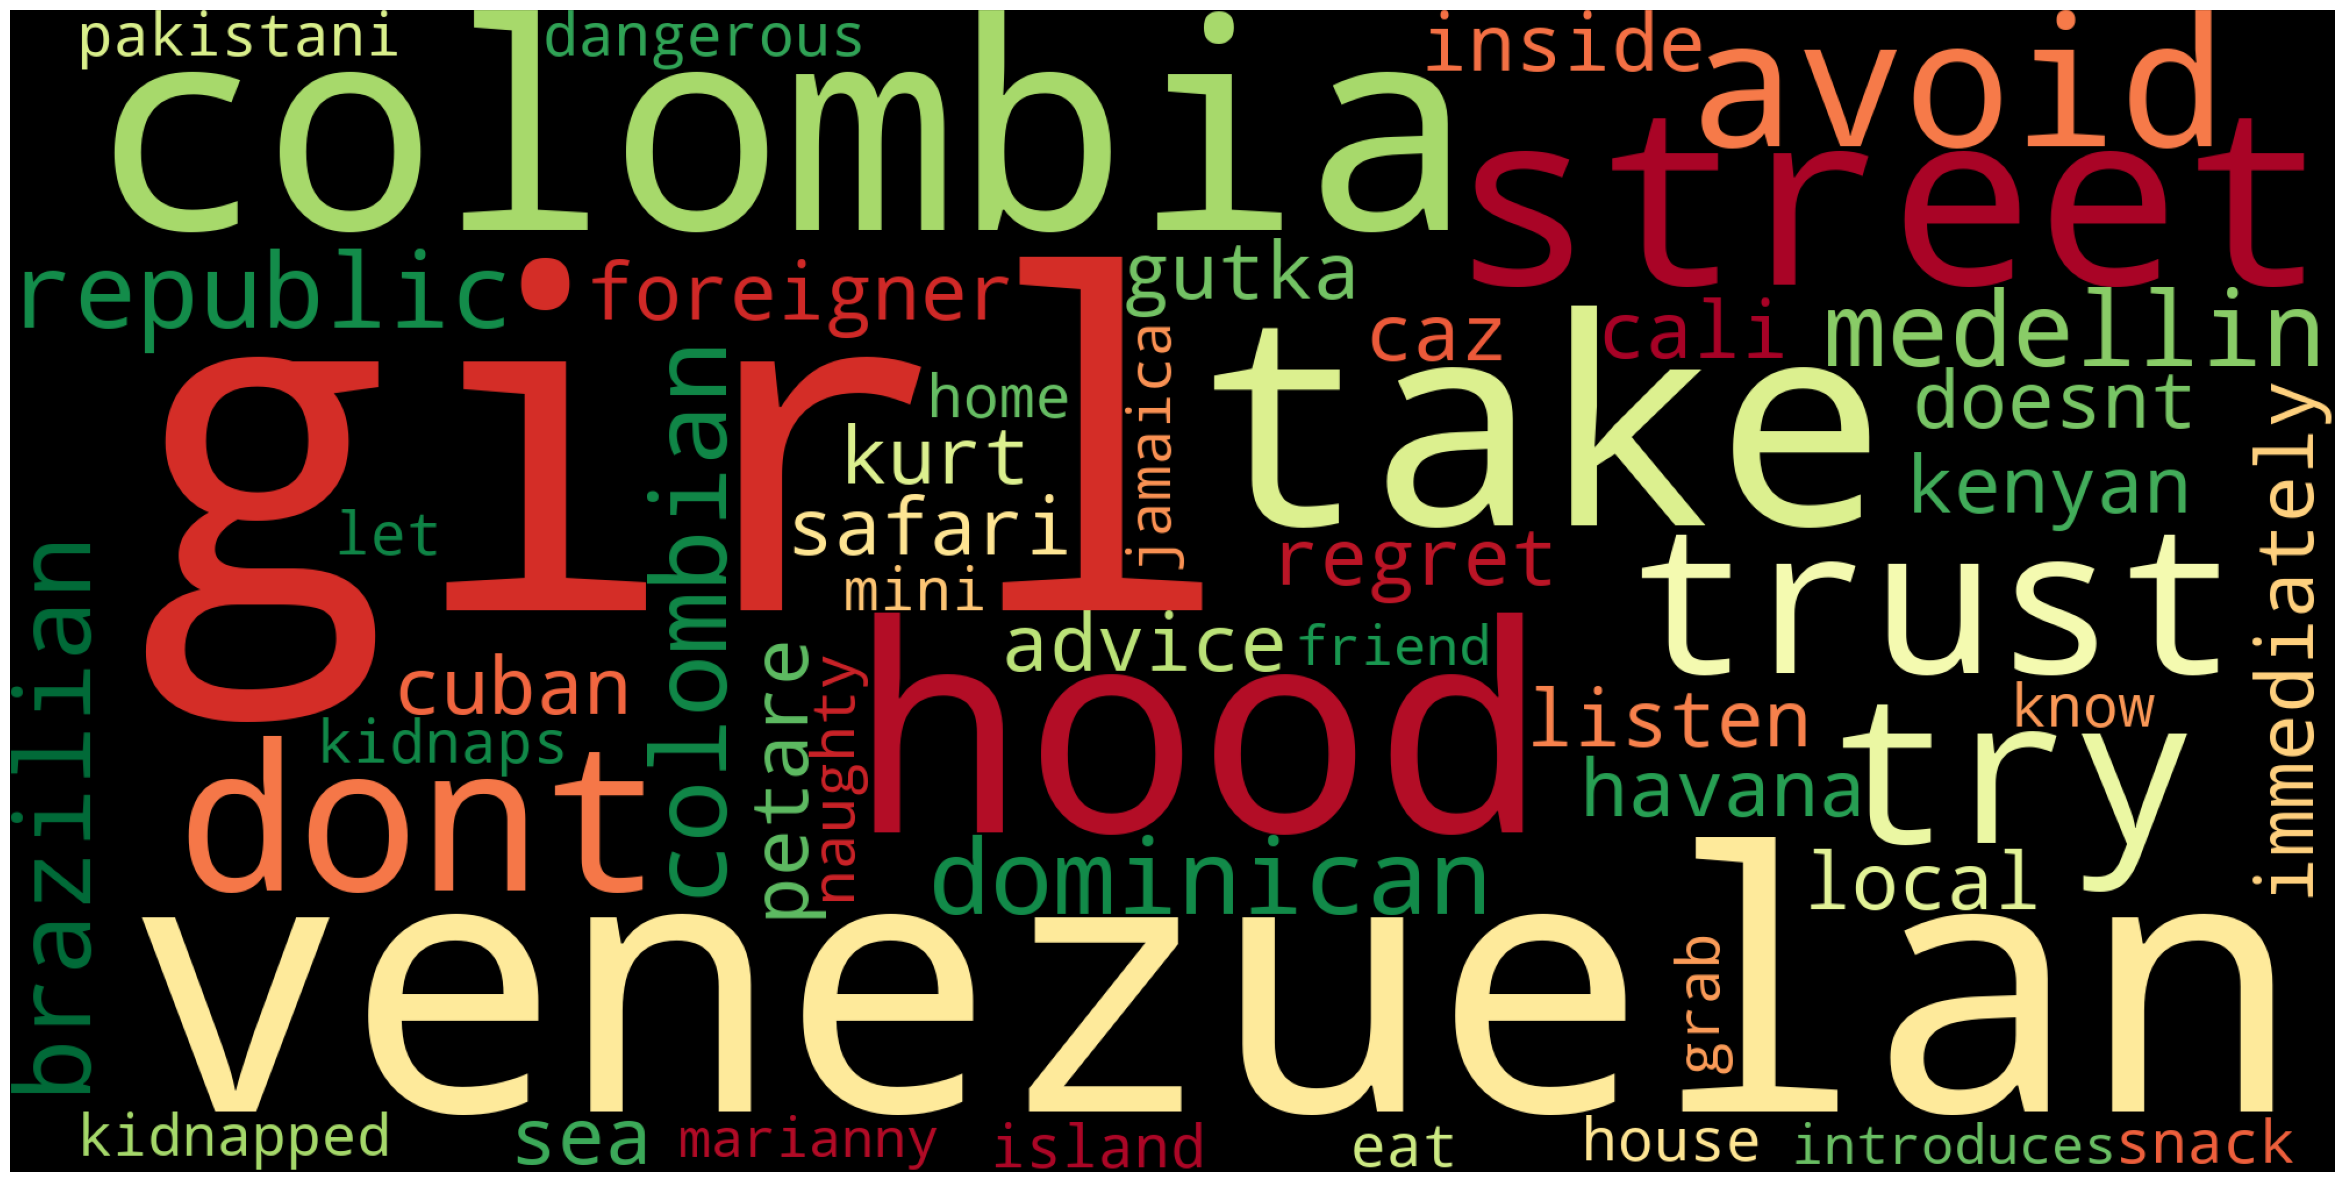

In [55]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black',
                      colormap='RdYlGn', collocations=False).generate(all_words_str)

plot_cloud(wordcloud)

#### Analysis

Above, I have created a wordcloud to represent the frequency of words used in the title of Kurt Caz's 20 most popular videos. The size of each word correlates to the number of times it appears in video titles.

As can be seen, the most common word used is "girl". It seems that viewers are keen to watch videos where Kurt meets girls out on his adventures. This word appeared in 9 of his top 20 viewed videos. If he wants to continue getting high numbers of views on his videos I would definitely recommend he makes more of these videos.

We can also see that the words "Colombia" and "Venezuela(n)" appear significantly in his most viewed videos. This indicates that videos filmed in these countries are ones that viewers of Kurt Caz's channel are particularly drawn to. In addition to this, words that are related to danger are in his titles as well - "don't", "trust", "avoid" and "dangerous" are all there. People are clearly interested in watching Kurt get into risky situations in his vlogs.

### 4. Sentiment Analysis of comments

In this final task, I will perform sentiment analysis on the comments of videos to see which content gets the best reaction from viewers. I will look at the average over a set of the top comments on videos, where each comment will be classified as positive or negative.

To do this I will use the Flair library. It is a simple and easy to use NLP library that has a varied range of uses. I will be using the TextClassifier from Flair which employs a DistilBERT pre-trained Transformer model.
You can read more about Flair [here](https://github.com/flairNLP/flair).

In [56]:
# Here is an example of how you can import a sentiment model and use it to predict sentiment of a comment.

classifier = TextClassifier.load('en-sentiment') # creating a variable which represents the model. 'en-sentiment' means the English language sentiment model
sentence = Sentence('The Travel Channel is really missing out. You are by far more entertaining than anyone they have on air.') # this is the Flair tokeniser
classifier.predict(sentence) # the 'predict' method here modifies the 'sentence' variable to add the predicted sentiment

sentiment = sentence.labels[0].value
score = sentence.labels[0].score
print(sentiment)
print(score)

POSITIVE
0.997610330581665


Now that I can see how the model works, I will apply it to comments of YouTube videos. I'll do this by taking comments from a comments dataframe.

In [57]:
def get_video_sentiments(comments_df):
    '''
    This function gives us the average sentiment as a numeric value from the top comments of a video
    
    Parameter: The comments_df passed into this function will be the output dataframe from the get_comments_in_videos function
    '''
    classifier = TextClassifier.load('en-sentiment') # this is a classifier from the Flair library
    
    video_sentiments_df = comments_df.copy() #  take a copy of the dataframe which has video_id and comments column
    video_sentiments_df['averageSentiment'] = np.nan # creating a new column in which I will add the sentiment score of the video
    
    for ind, row in video_sentiments_df.iterrows(): # iterating through each row in dataframe
        sentiments = []
        comments_list = row['comments']
        for comment in comments_list:  # for loop through each comment from the video
            sentence = Sentence(comment)
            classifier.predict(sentence)
            sentiment = sentence.labels[0].value # this is either "POSITIVE" or "NEGATIVE", indicating the predicted sentiment of the comment
            score = sentence.labels[0].score # this is a value between 0 and 1, indicating the confidence that the predicted sentiment is correct
            
            if sentiment == 'POSITIVE':  # in these lines I add the sentiment score to a list, making the value negative if it had a negative sentiment
                sentiments.append(score) 
            else:
                sentiments.append(-1*score)
        video_sentiments_df['averageSentiment'].iat[ind] = round(mean(sentiments), 3) 
        # In the line above we take the average sentiments from all the comments and add it to the row in the dataframe for that video
    
    return video_sentiments_df # Returning a copy of the dataframe which was given as the input parameter, having added a column for the average sentiment.

One thing to note from the function above is that I took into consideration the confidence level of the model that a particular sentiment calculated was in fact correct (I gave this variable name 'score' in the function). The reason I did this is because if one comment had 'POSITIVE' sentiment with a score of 0.01 and another was 'POSITIVE' with a score of 0.99, this will be because the positive sentiment that the model picked up in the first video is more ambiguous than that from the second. Thus it should have less of an impact on the averaged sentiment score of the video.

###### Finding the average sentiment for bald and bankrupts videos:

In [58]:
# Getting the dataframe that only contains video data from bald and bankrupt
bald_df = videos_df[videos_df['channelTitle'] == 'bald and bankrupt']
bald_video_ids = bald_df['video_id'].values

In [59]:
# Using the get_comments_in_videos function which was defined earlier
bald_comments_df = get_comments_in_videos(youtube, bald_video_ids)
bald_comments_df.head()

,video_id,comments
0,7dWfMMQslzU,[I’ve noticed a lot of snobby comments saying how grim and what a shithole M...
1,4ijIo8X2_h4,[My partner is from Caracas and I am trying to convince her to let me visit....
2,9I61plMS2Yg,"[I m in love whit Barbara, sorry but I m weak, 12:55, I fell in a hole just ..."
3,1m3fYellBlw,"[As a brazilian fan, that's NOT how I expected you would arrive in Brazil ha..."
4,41BqmsAUvwA,"[your language skills are out of this world, My lovely amazon.\nI hope you h..."


In [60]:
bald_sentiments_df = get_video_sentiments(bald_comments_df)
bald_sentiments_df.head()

,video_id,comments,averageSentiment
0,7dWfMMQslzU,[I’ve noticed a lot of snobby comments saying how grim and what a shithole M...,-0.307
1,4ijIo8X2_h4,[My partner is from Caracas and I am trying to convince her to let me visit....,0.367
2,9I61plMS2Yg,"[I m in love whit Barbara, sorry but I m weak, 12:55, I fell in a hole just ...",-0.085
3,1m3fYellBlw,"[As a brazilian fan, that's NOT how I expected you would arrive in Brazil ha...",-0.105
4,41BqmsAUvwA,"[your language skills are out of this world, My lovely amazon.\nI hope you h...",0.085


In [61]:
# Here I merge the sentiments dataframe with the full videos dataframe so that  I can see the video title and other 
# metadata that correspond to each predicted sentiment.

bald_sentiments_df = bald_sentiments_df.merge(bald_df, how = 'inner', on='video_id')
bald_sentiments_df = bald_sentiments_df[['video_id', 'title', 'viewCount', 'publishedAt', 'averageSentiment']]
bald_sentiments_df = bald_sentiments_df.sort_values('averageSentiment', ascending=False) # sorting the dataframe in descending order of sentiment

In [62]:
bald_top_sentiments = bald_sentiments_df.head(10) # Top 10 videos by average sentiment of comments
bald_bottom_sentiments = bald_sentiments_df.tail(10) # Bottom 10 videos

bald_bottom_sentiments = bald_bottom_sentiments.sort_values('averageSentiment') #putting worst sentiment at top of the dataframe

In [63]:
bald_top_sentiments

,video_id,title,viewCount,publishedAt,averageSentiment
123,oaletsYICyI,Drinking Vodka In A Soviet Apartment...What Could Go Wrong?!,6401088,2019-03-15 13:39:40,0.748
238,7ZjgtHhKBQw,Why I Returned To India After 20 Years,1333988,2018-07-15 12:31:23,0.694
115,50pQHccrlHg,I Got Drunk With Babushkas 🍷,3409057,2019-04-22 21:09:02,0.681
217,X8iKOnIBhsA,Tuva Blues: 'Adventures In Throat Singing',600471,2018-10-01 09:30:15,0.645
14,34XymEDY9Wc,Entering A Mysterious Exclave You've Never Heard Of ( In A Soviet Bi-plane ),3206179,2022-05-17 12:00:28,0.616
25,RPUsuDTnnFM,Looking For Love In A Ukrainian Village ( Isn't Easy ) 🇺🇦,1678515,2021-08-29 10:59:46,0.605
209,ZdLz4FjPU30,Khabib Returns To Dagestan ( UFC Part 6 ),828781,2018-10-09 04:39:25,0.599
19,D7t5Mgv5js0,I Got Drunk With Lithuania's Most Notorious Gangster 🇱🇹,2514289,2021-11-23 22:56:55,0.571
72,uIpiHofuFDQ,Hanging With The Elders Of Dagestan,2601122,2019-11-11 14:45:02,0.528
44,SrAA09YwDYo,Eating Cow Brain With Albanians 🇦🇱,1367342,2020-09-07 18:03:43,0.507


In [64]:
bald_bottom_sentiments

,video_id,title,viewCount,publishedAt,averageSentiment
228,ANyXBB4TMwY,Visiting Russia's Poorest Town 🇷🇺,3380995,2018-09-21 14:09:19,-0.876
118,wnDxHTaeNX0,Nobody Visits This Country...Find Out Why,11408668,2019-04-11 12:56:25,-0.586
108,PgzwGjaTr98,The Secret Soviet Nuclear Bunker 🇲🇩,2985338,2019-06-05 06:18:56,-0.570
204,V9NROzEVqMw,Is Karl Rock Right: Are Indians Scammers?,634896,2018-10-17 20:13:36,-0.524
95,cG4aYsvgchA,Partying In Europe's Biggest Slum | Lunik IX,3496777,2019-07-21 11:37:13,-0.486
203,PihyMGId-bg,India Street Food At The Delhi Funfair,1189693,2018-10-18 03:33:48,-0.484
57,wcseyA2aL8k,Could You Live In This Country? 🇨🇺,2821520,2020-02-17 21:10:12,-0.472
181,91w4GkdGfVA,Avoid This Guy In India! | Crazy Beggar,9756657,2018-11-12 18:36:50,-0.467
136,6fZQKoTEEBc,Money Necklace Social Experiment | Thieve's Market India 🇮🇳,519549,2019-02-11 08:14:36,-0.462
179,mwKgytCI3gs,I Almost Died In India //Terrifying Fairground Ride,2091509,2018-11-13 21:06:39,-0.445


In [65]:
print(len(bald_sentiments_df))
print(len(bald_sentiments_df[bald_sentiments_df['averageSentiment'] > 0]))

250
151


###### Repeating these steps for shiey's videos:

In [66]:
shiey_df = videos_df[videos_df['channelTitle'] == 'shiey']
shiey_video_ids = shiey_df['video_id'].values

shiey_comments_df = get_comments_in_videos(youtube, shiey_video_ids)
shiey_sentiments_df = get_video_sentiments(shiey_comments_df)

shiey_sentiments_df = shiey_sentiments_df.merge(shiey_df, how = 'inner', on='video_id')
shiey_sentiments_df = shiey_sentiments_df[['video_id', 'title', 'viewCount', 'publishedAt', 'averageSentiment']]

shiey_sentiments_df = shiey_sentiments_df.sort_values('averageSentiment', ascending=False) # sorting the dataframe in order of sentiment

In [67]:
shiey_top_sentiments = shiey_sentiments_df.head(10) # Top 10 videos by average sentiment of comments
shiey_bottom_sentiments = shiey_sentiments_df.tail(10) # Bottom 10 videos

shiey_bottom_sentiments = shiey_bottom_sentiments.sort_values('averageSentiment') #putting worst sentiment at top of the dataframe

In [68]:
shiey_top_sentiments

,video_id,title,viewCount,publishedAt,averageSentiment
41,aaiJ4TzcjeI,shiey - poem to a pigeon (Music Video),819656,2020-09-08 17:33:57,0.710
70,SbgxIvaieFk,shiey - distance (Song),350487,2019-06-02 07:11:54,0.618
54,q9bLdtNu6qc,Journey To The Black Sea | Part 2,539043,2020-01-31 23:09:17,0.524
117,hh82cgqftgM,Winter Rooftop Parkour Runs | POV,174436,2016-01-15 14:23:04,0.488
3,cj8slnNQVho,Cycling Journey To The Adriatic Sea | Part 2,635616,2023-06-09 18:22:37,0.476
22,Ky-Ny82ARPE,shiey - roaming (Music Video),441688,2022-05-05 19:22:10,0.469
31,nmSgGsqFYGw,Journey Across Bosnia & Herzegovina | Part 4,1297795,2021-06-19 19:00:37,0.456
78,I4yuNoecSrw,EVOLUTION OF CONFIDENCE,953499,2019-02-20 19:00:01,0.448
44,zW4IFAQfbn8,shiey - distance (Music Video),793829,2020-04-30 20:38:15,0.411
111,c_-T-xcXbXM,ILLEGAL FREEDOM | EP. 2 | The Long Day,384398,2016-07-12 17:38:04,0.407


In [69]:
shiey_bottom_sentiments

,video_id,title,viewCount,publishedAt,averageSentiment
69,TQtzCcg9p-E,We found foreign cars left in ABANDONED building.,1886065,2019-06-05 21:22:49,-0.570
52,WLLOCmX79y0,Mission To Huge Fully-Stocked Underground Safe House Complex,4915689,2020-02-12 20:10:48,-0.562
77,ShYA3xYW8wM,Found fully equipped bunker forgotten underground.,859629,2019-03-06 19:02:45,-0.525
45,ASTsRDSYXYs,Mission To Huge Abandoned Vehicle Storage Facility,1150821,2020-03-26 20:02:20,-0.464
109,qALp06OB3-8,USSR Bunker UNEXPECTED Exploration | POV,325998,2016-10-03 13:53:50,-0.460
98,vN0d6EprS04,TWICE ESCAPING Burnt Night Club AFTER Setting Off Alarm,983157,2017-04-28 23:45:42,-0.459
106,9HVSOGitwAE,exploring tv testing facility (semi-abandoned),179068,2017-01-08 20:38:33,-0.457
100,TkCGx_vO2Aw,Sneaking Into Somebody's Not So Abandoned House,1086544,2017-04-20 13:48:17,-0.428
63,qOqMSR51vAY,"Yes officer, I'm going to jump...",1278655,2019-09-10 18:04:44,-0.420
65,z2WDfset8FM,Journey Inside Abandoned City | Part 3,716524,2019-07-31 18:00:55,-0.375


In [70]:
print(len(shiey_sentiments_df))
print(len(shiey_sentiments_df[shiey_sentiments_df['averageSentiment'] > 0]))

122
69


#### Analysis

###### Bald and Bankrupt


* Bald's videos that have the most positive sentiment in the comments are ones where he is doing some real exploring or getting drunk with locals! The video with the highest average sentiment of 0.748 is him drinking in a Soviet apartment, and there are others like this in the top 10.
* For Mr Bald's least popular video in terms of sentiment, which has the title 'Visiting Russia's Poorest Town', people commenting negatively were not happy with how many times he mentioned throughout the video that the town he's exploring is poor (24 times according to one viewer). He may consider not emphasising this point in places like this in the future to not wind up viewers.
* Another point I noticed is that 3 of the videos from the top 10 with negative sentiment have some kind of negative connotation relating to India in the title i.e. 'Is Karl Rock Right: Are Indians Scammers?'. Even though he rarely continues the negative view of India in his actual video content, the controversial title appears to provoke people with varied opinions commenting, thus leading to a range in the sentiments.

###### Shiey

* Looking at shiey's top 10 videos by comment sentiment, one thing that is clear straight away is his music videos are among the best recieved. 4 of the the top 1o videos fall into this category, including the top 2. Bearing in mind that his channel is predominantly used to showcase his urban exploring and not the music he makes, this is very impressive and it indicates his talents in multiple areas!

* With his videos that had the most negative predicted sentiment, after inspecting the comments on these video I can see that usually the comments aren't actually negative remarks towards shiey for his video. For example, in the top video from shiey_bottom_sentiments dataframe titled 'We found foreign cars left in ABANDONED building.', most of the comments that would appear negative to the text classifier are actually simply stating that it is sad that nice cars are rotting away in an abandoned warehouse.

##### How many are positive or negative overall? How well did the model work?
* Bald and bankrupt has uploaded 250 videos, 153 of which have a mean positive sentiment (61%).
* shiey has uploaded 121 videos with 67 having an average sentiment that is positive (55%).
* These figures are close together which implies these two channels are have a similar reception from viewers.
* It should also be noted that I read through the comments for a selection of videos from both of these channels and it seems the model generally has a bias towards predicting negative sentiment in cases where the comments aren't actually negative. One reason for this was where viewers jokingly made negative comments and it can be inferred that they did in fact enjoy the video. This is one limitation of the video - the model can't interpret comments like these well.

## Conclusion

#### Findings
* bald and bankrupt has by far the most views on average across the channels that I analysed.
* The relationship between video duration and view count differs from vlogger to vlogger. However, with 4 out of the 6 that I looked at, there is some pattern between these 2 variables. This would allow the vlogger to develop a strategy to achieve greater views by aiming to make videos with their optimal length.
* Viewers of Kurt Caz's videos are more inclined to watch his videos when he has the word "girl" in the title. I beleive this is something he's aware of because after performing the analysis, I looked at his recently uploaded videos and saw that they regularly have videos with him meeting local girls in the places he is visiting.
* Bald and bankrupt's viewers love watching him getting drunk with locals and shiey's viewers are really keen on the videos he makes to accompany songs that he has produced.

#### Limitations
* Some of the patterns that I've seen are likely not a direct relation between the type of content produced and the success of the video. There are other factors that will have an impact - for example, all YouTube channels that are now successful have experienced an increase in their stats (views, likes, comments) through time as their channel grows. Therefore even if videos that a vlogger has made recently are not their best videos (this is of course subjective!), they may have the highest numbers in these categories.
* There are also many other factors that can impact the success of a video which I did not take into consideration. For example, an eye-catching thumbnail will certainly be linked to higher views.
* In the sentiment analysis of video commments, I only used the first 50 comments due to the quote limit of the YouTube API. It would have been interesting to pull the full list of comments when getting the average sentiment of videos.

#### Future areas to explore
* I would like to perform some time-series analysis on the YouTube data. For example, I could plot time-series graphs of each channels' view count to see how the channels have grown over time.
* Another interesting area to look at would be how the subscriber count has changed since the channels were created. This could then be combined with a timeline of when videos were uploaded to see which videos accelerated subscriber growth. The one issue with this is the subscriber count over time is not available through the YouTube API so I would have to find another data source. I found [this](https://socialblade.com/youtube/) website which contains cool graphs for subscriber count across time.
* I could look at building my own sentiment analysis model for the YouTube comments instead of utilising the pre-trained model from Flair. This can be done with Python libraries such as Tensorflow and PyTorch, and I could use YouTube comment data to train and then test the model.
* Apply this type of data analyis to another YouTube channel category. Following this I could compare the similarities and differences in the patterns between the types of video categories. I could also apply similar data analysis to another content type such as Netflix films/series once I have found a source for the data.

## Resources

* Thu Vu's GitHub page for her YouTube analysis https://github.com/thu-vu92/youtube-api-analysis/blob/main/Sample_project_youtube_videos_EDA.ipynb
* Information on top Matplotlib plots https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/
* Flair documentation https://flair.readthedocs.io/en/latest/
* Useful tutorial for Flair text classification model https://www.youtube.com/watch?v=DFtP1THE8fE 